In [5]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

In [69]:
reconstruction = np.load("./10_reconstruction.npy")
features = np.load("./10_features.npy")
gt = np.sum(plt.imread("./1_gt.png"), -1)/3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


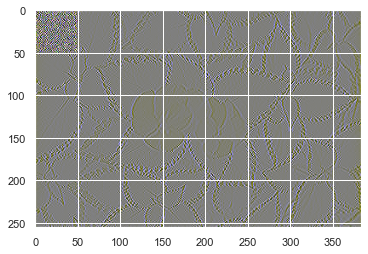

In [70]:
plt.imshow(features)

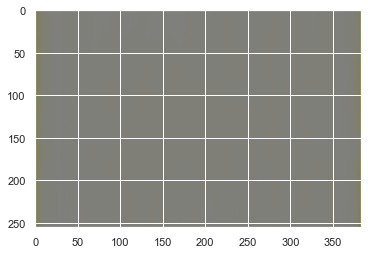

In [71]:
plt.imshow(reconstruction)

In [73]:
reconstruction

array([[[0.23502816, 0.21591236, 0.03033179],
        [0.34633641, 0.38507589, 0.25889278],
        [0.41620647, 0.44879563, 0.34528285],
        ...,
        [0.41723286, 0.41931093, 0.35674824],
        [0.46395445, 0.49919704, 0.40402299],
        [0.27192423, 0.25586358, 0.08084082]],

       [[0.35170829, 0.39090055, 0.01105788],
        [0.44299964, 0.47061218, 0.26217565],
        [0.4613704 , 0.46807788, 0.34210642],
        ...,
        [0.48654563, 0.49585678, 0.38421339],
        [0.4941524 , 0.48676122, 0.41322578],
        [0.43457876, 0.47035307, 0.11930783]],

       [[0.41271534, 0.44301782, 0.01251349],
        [0.44695672, 0.45499865, 0.25286975],
        [0.46697028, 0.47960238, 0.33679441],
        ...,
        [0.48933241, 0.49379788, 0.3859723 ],
        [0.48217837, 0.48663914, 0.38606551],
        [0.42995004, 0.43729569, 0.0824847 ]],

       ...,

       [[0.48404279, 0.49923768, 0.12018168],
        [0.4945954 , 0.49089095, 0.34101763],
        [0.48087362, 0

<AxesSubplot:>

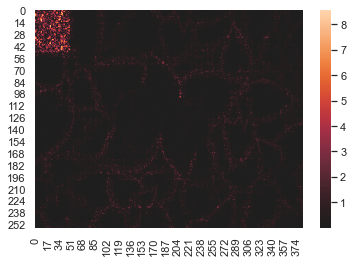

In [72]:
error = np.abs(features-reconstruction)
error = np.sum(error, axis=-1)
sns.heatmap(error, center=mean)

In [63]:
import scipy.stats